In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow
from src import models
import torch.nn.functional as F
from torchsummary import summary


mltrainer.__version__

'0.1.129'

In [2]:
confusion_matrixs = {}

In [3]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm, model_name):
    # Create the plot using seaborn
    plot = sns.heatmap(cfm, annot=True, fmt=".3f")
    
    # Set the labels for the axes
    plot.set(xlabel="Predicted", ylabel="Target")
    
    # Save the plot to a file with the model name in the filename
    plt.savefig(f"{model_name}_confusion_matrix.png", bbox_inches="tight")
    
    # Optionally, display the plot
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [4]:
def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart1D_oversampled",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )



            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_oversampled")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
               # "shape": config["shape"]
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [5]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

if torch.backends.mps.is_available():
            device = torch.device('mps')
            print('MPS is available')
else:
            device = torch.device('cpu')

{'ptb': 'heart', 'arrhythmia': 'heart_big'}
MPS is available


In [6]:
#choos dataset
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
#trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

# 1D MODELS

In [7]:
# 1D dataset
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")

In [8]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [9]:
x, y = traindataset[0]
x.shape

torch.Size([192, 1])

In [10]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

## CNN 1D + RESNET

{'model': 'CNN1DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'input_length': 192, 'shape': (1, 192)}


2025-02-01 20:30:24.380 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D_oversampled/20250201-203024
2025-02-01 20:30:24.694 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [09:39<00:00,  2.96it/s]
2025-02-01 20:40:44.285 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2078 test 0.2364 metric ['0.9180', '0.9180', '0.7346', '0.9180', '0.9392']
100%|██████████| 1718/1718 [09:35<00:00,  2.99it/s]
2025-02-01 20:50:59.457 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.0729 test 0.1330 metric ['0.9602', '0.9602', '0.8365', '0.9602', '0.9398']
100%|██████████| 1718/1718 [09:36<00:00,  2.98it/s]
2025-02-01 21:01:14.947 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0526 test 0.1042 metric ['0.9690', '0.9690', '0.8659', '0.9690', '0.9443']
100%|██████████| 1718/1718 [09:12<00:00,  3.11it/s]
2025-02-01 21:11:07.046 | INFO     | 

{'model': 'CNN1DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'input_length': 192, 'shape': (1, 192)}


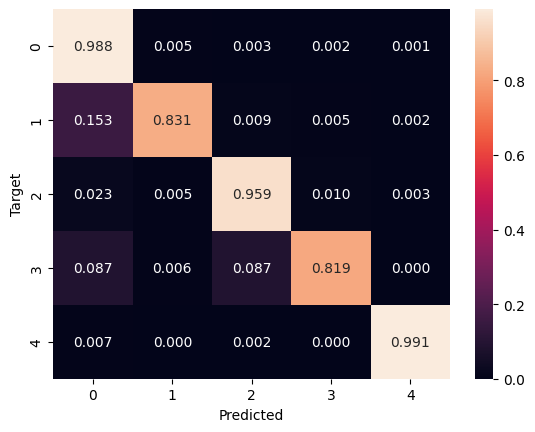

In [11]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )
if config['traindataset'] =='smote':
            settings.logdir="logs/heart1D_smote"

modelname= "CNN1DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "input_length": 192,
    "shape":(1, 192),
    'traindataset': 'oversampled'
   
}
if 'smote' in trainfile:
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'



print(config)
model = models.CNN1DResNet(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

# HYBRID MODEL 1D CNN + GRU + RESNET
To speed up the trining, combining a CNN with GRU seemed like a better option
The cnn runs in parallel instead of sequential

In [14]:
modelname= "CNN1DGRUResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "gru_hidden": 128,
    "hidden": 128,
    "dropout": 0.2,
    "num_layers": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "input_length": 192, 
    "input_size": 1, 
    "shape":(1, 192),
    'traindataset': 'oversampled'
}
if 'smote' in str(trainfile):
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'

print(config)
model = models.CNN1DGRUResNet(config)
print(model)
summary(model, input_size=(192, 1))
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

2025-02-02 10:11:43.769 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D_oversampled/20250202-101143
2025-02-02 10:11:43.769 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN1DGRUResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'gru_hidden': 128, 'hidden': 128, 'dropout': 0.2, 'num_layers': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'input_length': 192, 'input_size': 1, 'shape': (1, 192), 'traindataset': 'oversampled'}
CNN1DGRUResNet(
  (convolutions): ModuleList(
    (0): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResNetBlock1D(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.

100%|██████████| 1718/1718 [1:04:21<00:00,  2.25s/it]
2025-02-02 11:16:29.042 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5278 test 0.5324 metric ['0.8534', '0.8534', '0.6160', '0.8534', '0.8730']
100%|██████████| 1718/1718 [05:33<00:00,  5.16it/s]]
2025-02-02 11:22:25.646 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3905 test 0.5815 metric ['0.8415', '0.8415', '0.5836', '0.8415', '0.8450']
2025-02-02 11:22:25.647 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.5324, current loss 0.5815.Counter 1/8.
100%|██████████| 1718/1718 [05:32<00:00,  5.16it/s]]
2025-02-02 11:28:22.041 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3643 test 0.4705 metric ['0.8449', '0.8449', '0.6273', '0.8449', '0.8881']
100%|██████████| 1718/1718 [05:33<00:00,  5.16it/s]]
2025-02-02 11:34:19.001 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3271 test 0.4487 metric ['0.8516', '0.8516', '0.6248', '0.8516', '0.9060']
100%|██████████| 1718/1718 [0

{'model': 'CNN1DGRUResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'gru_hidden': 128, 'hidden': 128, 'dropout': 0.2, 'num_layers': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'input_length': 192, 'input_size': 1, 'shape': (1, 192), 'traindataset': 'oversampled'}


NameError: name 'modename' is not defined

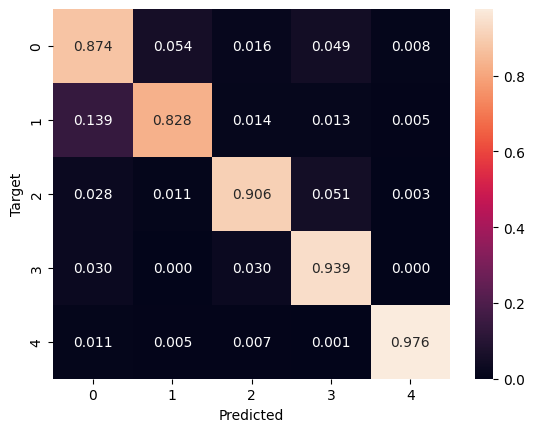

In [15]:
plot_confusion_matrix(cfm, modelname)

## 1D CNN + GRU + RESNET + MULTIHEAD ATTENTION

IDEA: adding multihead attention would help the CNN to focus on long term relations between datapoints, kind of supporting the memory component, retaining what's important.
Multi-Head Attention helps focus on important parts of the input sequence regardless of their position, which is particularly useful for learning global relationships between distant time steps, identifying long-term temporal patterns in ECG signals.

Tested: with Average vs Max Pooling
Max pooling seems the best choice since the data does not need to smoothed out, the features which are interesting are the peaks which are detected with a max pooling
Unlike average pooling, which smooths out the signal and can cause the loss of important high-frequency features, max pooling retains the strongest features in each local region. This can be especially helpful in cases where the model needs to focus on specific events (e.g., irregular heartbeats or spikes in ECG data).

In [ ]:
modelname= "CNN1DGRUResNetMH"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "gru_hidden": 128,
    "hidden": 128,
    "dropout": 0.2,
    "num_layers": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "input_length": 192, 
    "input_size": 1, 
    "shape":(1, 192),
    'traindataset': 'oversampled'
}
if 'smote' in str(trainfile):
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'

print(config)
model = models.CNN1DGRUResNetMH(config)
print(model)
summary(model, input_size=(192, 1))
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

2025/02/02 12:19:36 INFO mlflow.tracking.fluent: Experiment with name 'CNN1DGRUResNetMH' does not exist. Creating a new experiment.
2025-02-02 12:19:36.779 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D_oversampled/20250202-121936
2025-02-02 12:19:36.779 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN1DGRUResNetMH', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'gru_hidden': 128, 'hidden': 128, 'dropout': 0.2, 'num_layers': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'input_length': 192, 'input_size': 1, 'shape': (1, 192), 'traindataset': 'oversampled'}
CNN1DGRUResNetMH(
  (convolutions): ModuleList(
    (0): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResNetBlock1D(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(128, eps=1e-05, momentu

  0%|          | 0/10 [00:00<?, ?it/s]

# 1D TRANSFORMER MODELS

 ## TRANSFORMER 1D CNN

In [ ]:

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )


modelname= "Transformer1D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in trainfile:
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'


print(config)
model = models.Transformer(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modename)

## 1D transformer + RESNET

In [ ]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )


modelname= "Transformer1DResnet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in trainfile:
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'


print(config)
model = models.Transformer1DResnet(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modename)

## 1D TRANSFOMER + RESNET + SQUEEZE AND EXCITE
- The SE block would help compact the feature representation through global pooling and speed traing


In [ ]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )


modelname= "Transformer1DResnetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in trainfile:
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'


print(config)
model = models.Transformer1DResnetSE(config)
yhat = model(x)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modename)

## TRANSFORMER + RESNET + SE + MULTIHEAD ATTENTION

In [ ]:

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )


modelname= "Transformer1DResnetSEwithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in trainfile:
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'


print(config)
model = models.Transformer1DResnetSEwithAttention(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modename)

In [ ]:
 # testing types of seeds

In [22]:
from datetime import datetime

# Get current date and time in a specific format (e.g., '2025-01-28_15-30-45')
current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Hash the string to create a seed
random_seed = hash(current_time_str)
print(f"Random Seed from Date and Time (hashed): {random_seed}")
current_time_str

Random Seed from Date and Time (hashed): 1902171767351478533


'2025-01-30_11-57-17'

In [23]:
import time

# Use the current date and time to generate a more unique seed
current_time_str = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
random_seed = int(time.mktime(time.strptime(current_time_str, "%Y-%m-%d %H:%M:%S")))
print(f"Random Seed from Date and Time: {random_seed}")

Random Seed from Date and Time: 1738234650


In [24]:
import random

# Generate a random integer between 0 and 2^32 - 1
random_seed = random.randint(0, 2**32 - 1)
print(f"Random Seed: {random_seed}")

Random Seed: 2921403402
